In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install -U -q PyDrive

In [4]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/CoNSeP')
try:
  os.makedirs(local_download_path)
except: pass

def load_files_to_colab(folder_id, des_path):
  # 2. Auto-iterate using the query syntax
  #    https://developers.google.com/drive/v2/web/search-parameters
  file_list = drive.ListFile(
      {'q': "'{}' in parents".format(folder_id)}).GetList()

  local_download_path = os.path.expanduser('~/CoNSeP/{}'.format(des_path))
  try:
    os.makedirs(local_download_path)
  except: pass

  for f in file_list:
    # 3. Create & download by id.
    #print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    #print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

In [6]:
import tqdm 
files_to_load = {
    'Test/Images': '1bvUzfYfj-_6vXMYMz-slJLpABUBNzqAZ',
    'Test/Labels': '1NUbVnkXZ4tccVm6olTohhoZnqNdc3gKm',
    'Test/Overlay': '1qUvAQDvsGpwqX6fTlLnqQSwseHA1CHt8',
    'Train/Images': '1N2N40aS9oSk8F1ruWxMXEL-r914t9i9c',
    'Train/Labels': '1HREv-wEWg2oln_vicfq3A1CKmlgtPEdK',
    'Train/Overlay': '1ZbPYYr8tJRQer6UnJN3wWpxX2sMv3Ibo'
}

for des_path, folder_id in tqdm.tqdm(files_to_load.items()):
  load_files_to_colab(folder_id, des_path)

100%|██████████| 6/6 [01:26<00:00, 14.46s/it]


In [7]:
load_files_to_colab('1N2N40aS9oSk8F1ruWxMXEL-r914t9i9c', 'hi')

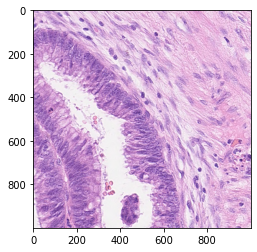

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/root/CoNSeP/Train/Images/train_14.png')
  
# Output Images
plt.imshow(img)